# Setup

In [1]:
BATCH_SIZE = 7

In [2]:
import torch
from augmentations import gaussian_noise
from torch.utils.data import Dataset, DataLoader
from dataset import ThesisImageFolder, ThesisTensorDataset

In [3]:
def augmented_batch(batch):
    """"
    Proccesses a batch of data sequentially (in the form) of an iterable
    to return a batch of pairs (1st image, 1st img. augmented, second image, 2nd img. augmented, etc.)
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 2 * num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    # format: (batch_size, 2 for (original, augmented) * num_channels, height, width)
    # images_batch = torch.zeros((batch_size, 3, nc, h, w))
    images_batch = torch.zeros((batch_size * 2, nc, h, w))
    
    for i in range(batch_size):         
        first_image = batch[i]
        # first_image_augmented = discrete_random_rotate(batch[i])
        first_image_augmented = gaussian_noise(batch[i])

        images_batch[2*i, :, :, :] = first_image
        images_batch[2*i+1, :, :, :] = first_image_augmented

    return images_batch



def augmented_batch_2tuple(lst_3_tup_data_pts):
    """
    Processes a list of tuples, each with size 2 (two randomly selected data points),
    and returns a tuple of size 2, one with the augmented batch with the first elements
    and the other with the augmented batch with the second elements.
    """
    # zip does basically does the equivalent as the below commented out lines of code
    # data_pts_to_augment = tuple(tup[0] for tup in lst_3_tup_data_pts)
    # random_datapts_1 = tuple(tup[1] for tup in lst_3_tup_data_pts])
    # random_datapts_2 = tuple(tup[2] for tup in lst_3_tup_data_pts)
    data_pts_to_augment, random_datapts_1, random_datapts_2 = zip(*lst_3_tup_data_pts)

    aug_batch = augmented_batch(data_pts_to_augment)
    rand_batch = torch.stack(random_datapts_1 + random_datapts_2)

    assert len(aug_batch) == len(rand_batch)

    return aug_batch, rand_batch


In [4]:
def show_pairs_in_batch(dataloader: DataLoader):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(BATCH_SIZE, 2, figsize=(14, 14))

    batch = next(iter(dataloader))

    # shape: (14, num_channels, 64, 64)
    # print(batch[0].shape, batch[1].shape)

    titles = ['Image 1', 'Augmented']

    for image_idx, image in enumerate(batch[0]):
        batch_idx, pair_idx = image_idx // 2, image_idx % 2
        axs[batch_idx, pair_idx].imshow(torch.permute(image, (1,2,0)))
        axs[batch_idx, pair_idx].set_title(titles[pair_idx])
    
    fig.suptitle(f'Batch of {BATCH_SIZE} Pairs')
    plt.show()

# CelebA

In [5]:
from pathlib import Path

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])


base_path = Path('.').absolute().parent / 'Disentangling' / 'data'


train_kwargs = {'root': base_path / 'CelebA', 'transform': transform}
celeba_data = ThesisImageFolder(**train_kwargs)

In [7]:
len(celeba_data)

202599

In [8]:
celeba_dataloader = DataLoader(celeba_data, batch_size=BATCH_SIZE, 
                               collate_fn=augmented_batch_2tuple, shuffle=True)

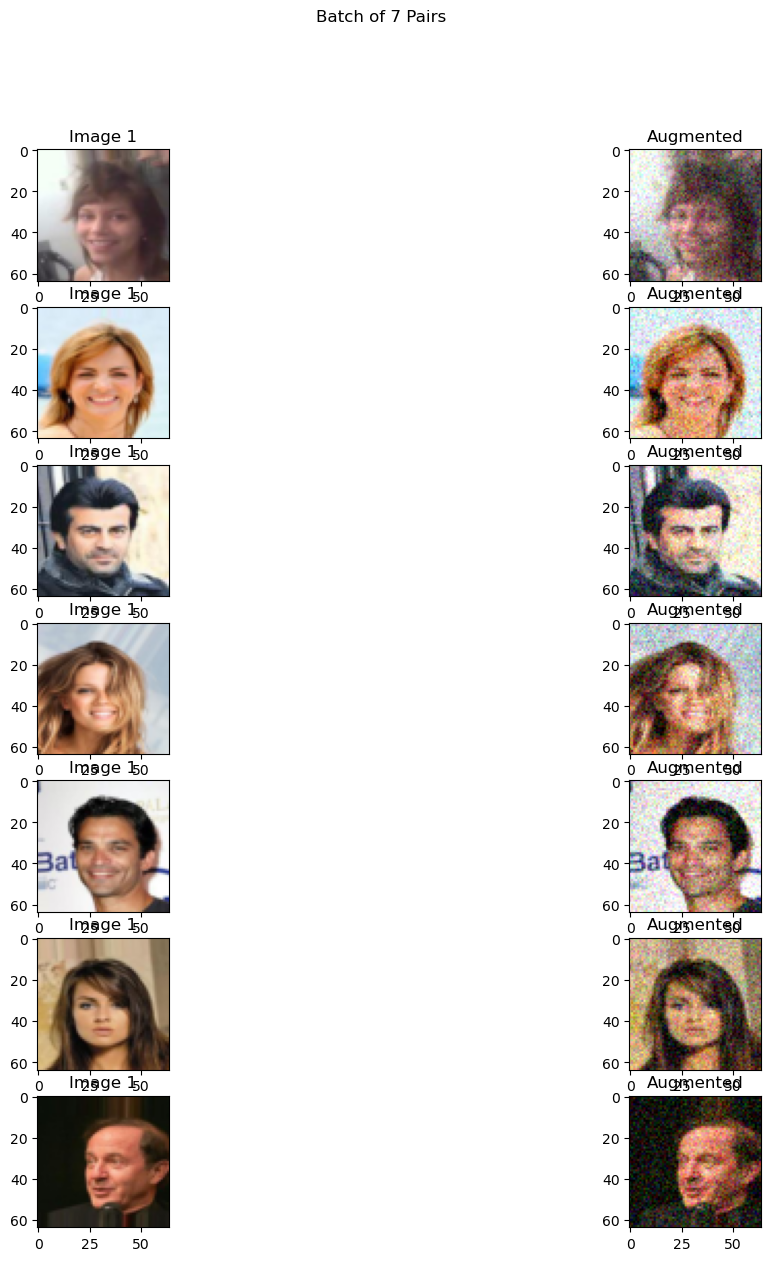

In [9]:
show_pairs_in_batch(celeba_dataloader)

# 3DChairs

In [10]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': base_path / '3DChairs', 'transform': transform}
chairs3D_data = ThesisImageFolder(**train_kwargs)

In [11]:
chairs3D_dataloader = DataLoader(chairs3D_data, batch_size=BATCH_SIZE, 
                                 collate_fn=augmented_batch_2tuple, shuffle=True)

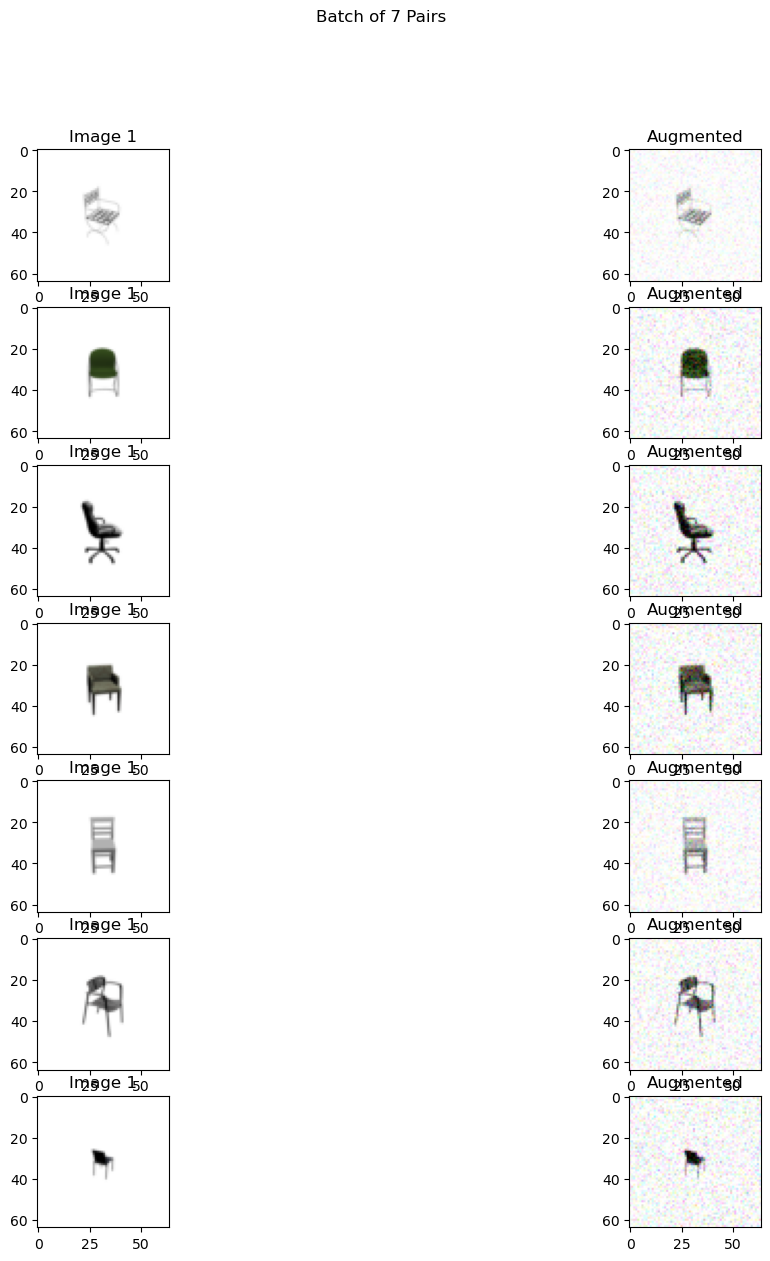

In [12]:
show_pairs_in_batch(chairs3D_dataloader)

# dSprites

In [13]:
import numpy as np
dSprites_data = np.load("./data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
dSprites_data = torch.from_numpy(dSprites_data['imgs']).unsqueeze(1).float()

In [14]:
dSprites_dataset = ThesisTensorDataset(data_tensor = dSprites_data)
dSprites_dataloader = DataLoader(dSprites_dataset, batch_size=BATCH_SIZE, 
                                 collate_fn=augmented_batch_2tuple, shuffle=True)

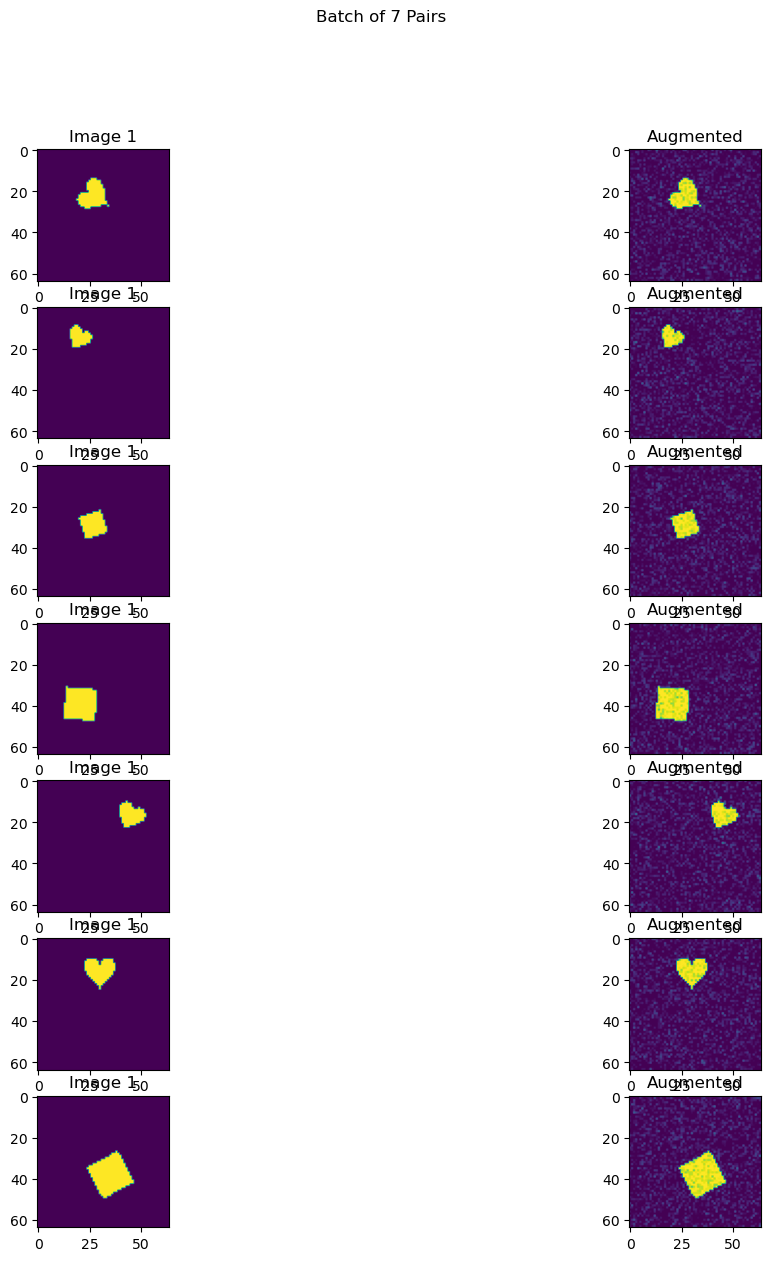

In [15]:
show_pairs_in_batch(dSprites_dataloader)